In [40]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils import rnmse
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from skorch import NeuralNet
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_palette('hot', n_colors=7)

In [2]:
x = torch.cat([torch.load("dataset/x_train.pt"), torch.load("dataset/x_train_2.pt")])
y = torch.cat([torch.load("dataset/y_train.pt"), torch.load("dataset/y_train_2.pt")])
c = torch.cat([torch.load("dataset/c_train.pt"), torch.load("dataset/c_train_2.pt")])

x_test = torch.load("dataset/x_test.pt")
y_test = torch.load("dataset/y_test.pt")
c_test = torch.load("dataset/c_test.pt")

In [3]:
x0, y0, c0 = x[0], y[0], c[0]

In [4]:
x0.shape

torch.Size([256, 128])

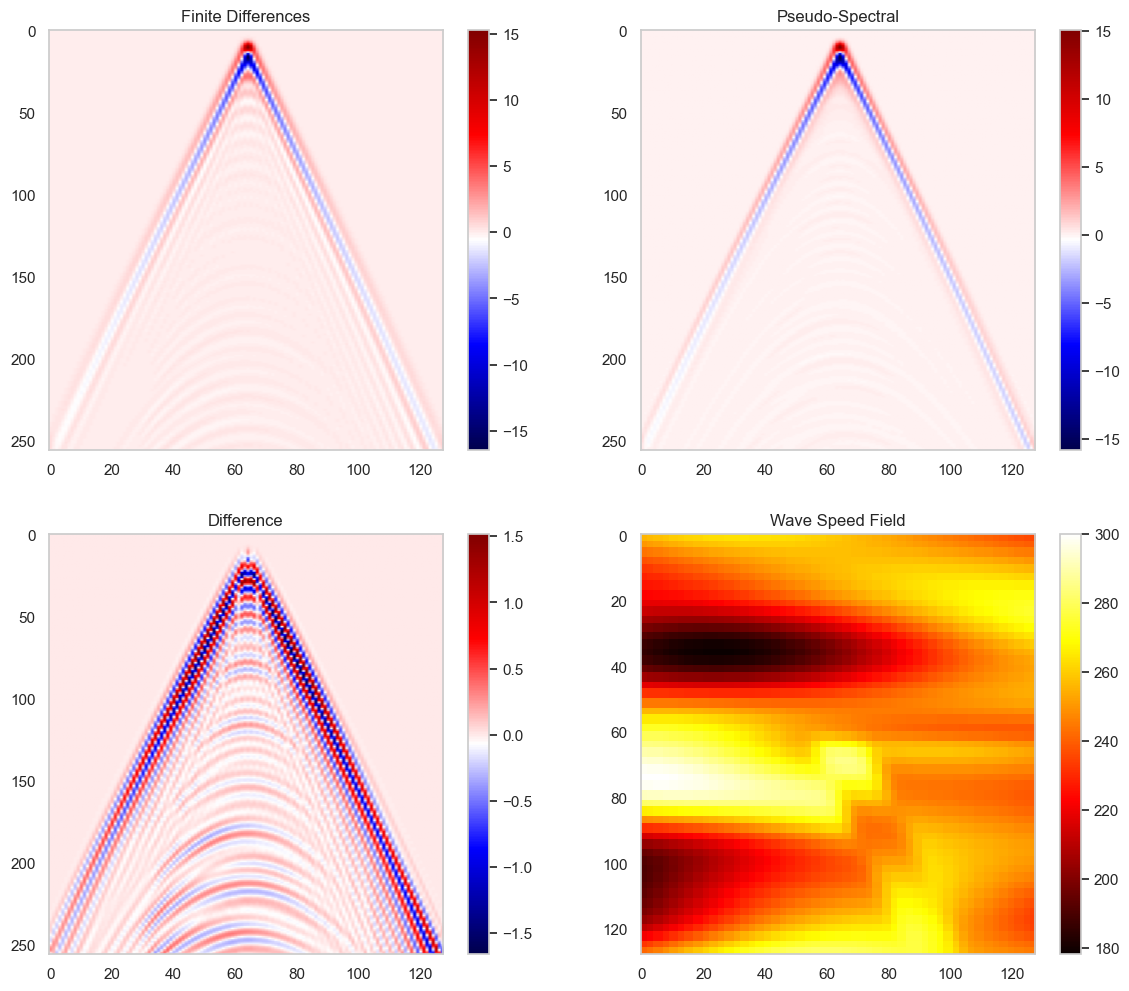

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))
m = ax[0, 0].imshow(x0, aspect='auto', cmap='seismic')
ax[0, 0].set_title("Finite Differences")
plt.colorbar(m)
ax[0, 0].grid(False)
m = ax[0, 1].imshow(y0, aspect='auto', cmap='seismic')
ax[0, 1].set_title("Pseudo-Spectral")
ax[0, 1].grid(False)
plt.colorbar(m)
m = ax[1, 0].imshow((x0-y0), aspect='auto', cmap='seismic')
ax[1, 0].set_title("Difference")
ax[1, 0].grid(False)
plt.colorbar(m)
m = ax[1, 1].imshow(c0, aspect='auto', cmap='hot')
ax[1, 1].set_title("Wave Speed Field")
ax[1, 1].grid(False)
plt.colorbar(m)
plt.savefig("sample_example.jpg", dpi=150)
plt.show()

The initial error between FD and PS is evaluated.

In [6]:
print(f"Train RNSME: {rnmse(x, y)}")
print(f"Test RNSME: {rnmse(x_test, y_test)}")

Train RNSME: 0.38560399413108826
Test RNSME: 0.38336923718452454


First question: how well can the problem of getting $y$ (PS), knowing $x$ (FD) using a linear regression be solved ?

In [7]:
x_np, y_np, c_np = x.numpy(), y.numpy(), c.numpy()
x_np_reshaped, y_np_reshaped, c_np_reshaped = x_np.reshape((x_np.shape[0], -1)), y_np.reshape((y_np.shape[0], -1)), c_np.reshape((c_np.shape[0], -1))
x_test_np, y_test_np, c_test_np = x_test.numpy(), y_test.numpy(), c_test.numpy()
x_test_np_reshaped, y_test_np_reshaped, c_test_np_reshaped = x_test_np.reshape((x_test_np.shape[0], -1)), y_test_np.reshape((y_test_np.shape[0], -1)), c_test_np.reshape((c_test_np.shape[0], -1))

In [8]:
print(torch.mean(y-x))
print(torch.std(y-x))

tensor(5.1787e-07)
tensor(0.2418)


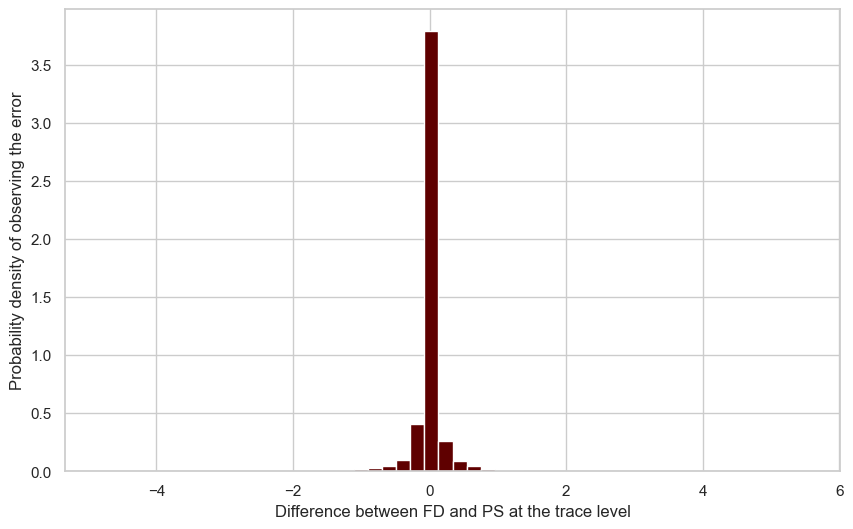

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(y_np[:1024].flatten()-x_np[:1024].flatten(), density=True, bins=50)
plt.grid(True)
plt.xlabel("Difference between FD and PS at the trace level")
plt.ylabel("Probability density of observing the error")
plt.savefig("error_analysis.jpg", dpi=150)
plt.show()

In [10]:
PCA_eval = False
if PCA_eval:
    pca_errors = {}
    for n_components in tqdm([2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]):
        pca_x = PCA(n_components=n_components).fit(x_np)
        pca_y = PCA(n_components=n_components).fit(x_np)
        x_pca = pca_x.transform(x_np)
        y_pca = pca_y.transform(y_np)
        x_test_pca = pca_x.transform(x_test_np)
        y_test_pca = pca_y.transform(y_test_np)
        lm = LinearRegression().fit(x_pca, y_pca)
        y_test_hat = pca_y.inverse_transform(lm.predict(x_test_pca))
        pca_errors[n_components] = rnmse(y_test_np, y_test_hat)
    plt.figure(figsize=(7, 7))
    plt.scatter(pca_errors.keys(), pca_errors.values())
    plt.grid()
    plt.xlabel("Number of PCA components")
    plt.ylabel("RNMSE")
    plt.savefig('pca_error.jpg', dpi=150)

Now we try a MLP.

In [11]:
n_components = 256

In [12]:
class MLP(nn.Module):
    def __init__(self, input_dim=n_components, output_dim=n_components):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return x + self.net(x)

In [13]:
class MLP2(nn.Module):
    def __init__(self, input_dim=128, output_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return x + self.net(x.unsqueeze(0)).squeeze()

In [14]:
class CNN(nn.Module):
    def __init__(self, input_dim=n_components, output_dim=n_components):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return x + self.head(self.features(x.unsqueeze(1)))

In [16]:
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv2d(16, 1, kernel_size=3, padding='same'),
        )

    def forward(self, x):
        x = x.unsqueeze(1)
        return (x + self.features(x)).squeeze()

Now we do the cross validation for each of the models.

In [17]:
def scorer_rnmse(estimator, x, y):
    return rnmse(estimator.predict(x), y)

def get_rnmse():
    return rnmse

In [18]:
device = 'mps'
n_points = 10000
scores = {}

In [41]:
pipe_lm = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("lm", LinearRegression(n_jobs=-1))
    ]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_mlp = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("mlp", NeuralNet(
            MLP,
            max_epochs=32,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_mlp2 = Pipeline([
        ("mlp", NeuralNet(
            MLP2,
            max_epochs=32,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))])

pipe_cnn = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("cnn", NeuralNet(
            CNN,
            max_epochs=32,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

pipe_cnn2 = Pipeline([
        ("mlp", NeuralNet(
            CNN2,
            max_epochs=32,
            criterion=get_rnmse,
            optimizer=optim.Adam,
            lr=1e-3,
            iterator_train__shuffle=False,
            device=device
        ))])

pipe_gbm = TransformedTargetRegressor(
    regressor=Pipeline([
        ("pca", PCA(n_components=n_components)),
        ("gmb", ExtraTreesRegressor())
    ]),
    transformer=PCA(n_components=n_components),
    check_inverse=False
)

In [20]:
scores["LM"] = cross_val_score(
    pipe_lm,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

In [21]:
scores["MLP on PCA"] = cross_val_score(
    pipe_mlp,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7874        0.7185  0.4415
      2        0.6258        0.5419  0.1559
      3        0.5065        0.4713  0.1536
      4        0.4541        0.4406  0.1560
      5        0.4293        0.4221  0.1622
      6        0.4121        0.4075  0.1657
      7        0.3984        0.3951  0.1741
      8        0.3865        0.3849  0.1673
      9        0.3761        0.3764  0.1629
     10        0.3670        0.3690  0.1671
     11        0.3588        0.3622  0.1680
     12        0.3515        0.3562  0.1727
     13        0.3451        0.3511  0.1752
     14        0.3395        0.3468  0.1623
     15        0.3347        0.3430  0.1642
     16        0.3304        0.3397  0.1623
     17        0.3266        0.3360  0.1623
     18        0.3230        0.3344  0.1703
     19        0.3203        0.3306  0.1664
     20        0.3179        0.3296  0.1658
     21        0.3147        0.3

In [22]:
scores["CNN on PCA"] = cross_val_score(
    pipe_cnn,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.7121        0.5459  0.6167
      2        0.4673        0.4167  0.5201
      3        0.3943        0.3759  0.5144
      4        0.3646        0.3552  0.5156
      5        0.3470        0.3399  0.5144
      6        0.3329        0.3329  0.5152
      7        0.3233        0.3251  0.5149
      8        0.3146        0.3148  0.5142
      9        0.3080        0.3091  0.5136
     10        0.3023        0.3030  0.5154
     11        0.2959        0.2985  0.5135
     12        0.2911        0.2951  0.5156
     13        0.2876        0.2916  0.5171
     14        0.2844        0.2905  0.5135
     15        0.2820        0.2891  0.5138
     16        0.2797        0.2838  0.5173
     17        0.2774        0.2843  0.5150
     18        0.2742        0.2795  0.5171
     19        0.2707        0.2797  0.5157
     20        0.2699        0.2792  0.5133
     21        0.2706        0.2

In [23]:
scores

{'LM': array([0.10289332, 0.10674433, 0.10440236, 0.10197225, 0.11189571]),
 'MLP on PCA': array([0.22037373, 0.22692001, 0.23442452, 0.21981162, 0.22850406]),
 'CNN on PCA': array([0.19490683, 0.18735686, 0.19934979, 0.18923286, 0.20272984])}

In [24]:
scores["MLP on Original Data"] = cross_val_score(
    pipe_mlp2,
    x_np[:n_points], y_np[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.3547        0.2911  3.0477
      2        0.2543        0.2220  1.2872
      3        0.2104        0.1971  1.2789
      4        0.1938        0.1869  1.2667
      5        0.1863        0.1811  1.2438
      6        0.1811        0.1767  1.2412
      7        0.1773        0.1736  1.2218
      8        0.1743        0.1711  1.2211
      9        0.1721        0.1693  1.4788
     10        0.1704        0.1677  1.6692
     11        0.1690        0.1664  1.2368
     12        0.1678        0.1653  1.2123
     13        0.1667        0.1643  1.2127
     14        0.1658        0.1634  1.1918
     15        0.1649        0.1627  1.1915
     16        0.1642        0.1618  1.1859
     17        0.1634        0.1611  1.1669
     18        0.1627        0.1604  1.1528
     19        0.1621        0.1599  1.1388
     20        0.1615        0.1594  1.1367
     21        0.1609        0.1

In [25]:
scores["CNN on Original Data"] = cross_val_score(
    pipe_cnn2,
    x_np[:n_points], y_np[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.2528        0.1966  27.3089
      2        0.1774        0.1669  27.8952
      3        0.1589        0.1556  26.6184
      4        0.1503        0.1497  25.5069
      5        0.1461        0.1449  31.1320
      6        0.1419        0.1413  26.6639
      7        0.1396        0.1402  27.5961
      8        0.1376        0.1421  26.8013
      9        0.1366        0.1352  27.7571
     10        0.1343        0.1336  25.7559
     11        0.1343        0.1334  25.9188
     12        0.1318        0.1312  29.3565
     13        0.1309        0.1303  27.5791
     14        0.1301        0.1297  30.7320
     15        0.1292        0.1287  34.2623
     16        0.1283        0.1279  36.0664
     17        0.1275        0.1270  35.3107
     18        0.1268        0.1270  34.2284
     19        0.1262        0.1257  34.3972
     20        0.1252        0.1254  33.1230
     21   

In [26]:
scores

{'LM': array([0.10289332, 0.10674433, 0.10440236, 0.10197225, 0.11189571]),
 'MLP on PCA': array([0.22037373, 0.22692001, 0.23442452, 0.21981162, 0.22850406]),
 'CNN on PCA': array([0.19490683, 0.18735686, 0.19934979, 0.18923286, 0.20272984]),
 'MLP on Original Data': array([0.15375297, 0.15774027, 0.15708622, 0.15412289, 0.15871112]),
 'CNN on Original Data': array([0.11704013, 0.11991625, 0.11587704, 0.11217886, 0.11447032])}

In [ ]:
scores["GBM on PCA"] = cross_val_score(
    pipe_gbm,
    x_np_reshaped[:n_points], y_np_reshaped[:n_points],
    cv=5,
    scoring=scorer_rnmse
)

In [ ]:
scores

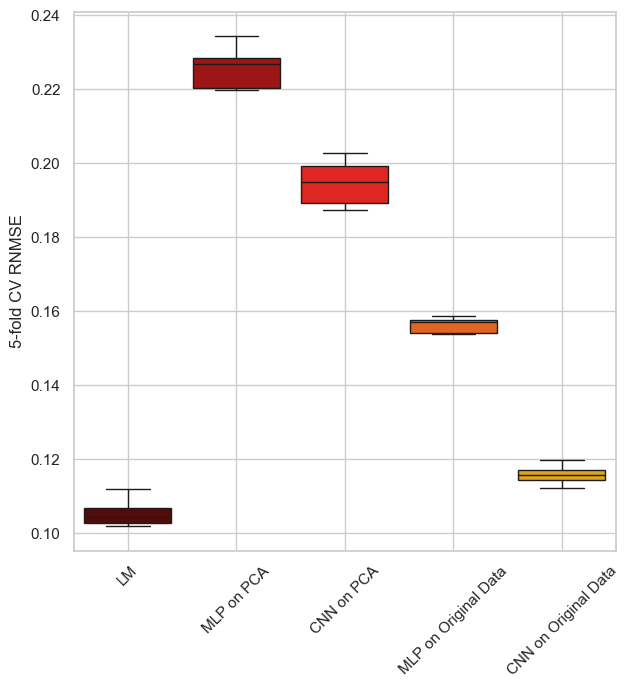

In [27]:
plt.figure(figsize=(7, 7))
sns.boxplot(pd.DataFrame(scores))
plt.grid(True)
plt.ylabel("5-fold CV RNMSE")
plt.xticks(rotation=45)
plt.savefig("5cvrnmse.jpg", dpi=150)
plt.show()